In [20]:
import numpy as np
import pandas as pd
import torch
import gpytorch
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel
from gpytorch.distributions import MultivariateNormal
import matplotlib.pyplot as plt


#`source /cvmfs/sft.cern.ch/lcg/views/LCG_102/x86_64-centos7-gcc11-opt/setup.sh`
from glob import glob
from tqdm import tqdm
import yoda2numpy_BayesOpt
from yoda2numpy_BayesOpt import Yoda2Numpy

import pythia_SBI_utils
from pythia_SBI_utils import *

FONTSIZE = 14
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : FONTSIZE}
mp.rc('font', **font)

# set usetex = False if LaTex is not 
# available on your system or if the 
# rendering is too slow
mp.rc('text', usetex=True)


In [21]:
def make_pythia_card(aLund, 
                    #  bLund,
                    # aExtraSQuark,
                    # sigma,
                    # enhancedFraction,
                    # ProbStoUD,
                    # probQQtoQ,
                    # probSQtoQQ,
                    # alphaSvalue,
                    # pTmin
                    ):
    
    cards_dir = os.path.join(os.getcwd(), "BO_Cards")
    filename = f"ALEPH_1996_S3486095_BO_card.cmnd"
    file_path = os.path.join(cards_dir, filename)
    with open(file_path,'w') as f:
        first_block="""Main:numberOfEvents = 500          ! number of events to generate
Next:numberShowEvent = 0           ! suppress full listing of first events
# random seed
Random:setSeed = on
Random:seed= 0
! 2) Beam parameter settings.
Beams:idA = 11                ! first beam,  e- = 11
Beams:idB = -11                ! second beam, e+ = -11
Beams:eCM = 91.2               ! CM energy of collision
# Pythia 8 settings for LEP
# Hadronic decays including b quarks, with ISR photons switched off
WeakSingleBoson:ffbar2gmZ = on
23:onMode = off
23:onIfAny = 1 2 3 4 5
PDF:lepton = off
SpaceShower:QEDshowerByL = off\n\n"""
        f.write(first_block)
        # f.write(f"Random:seed={indx+1}")
        f.write(f"StringZ:aLund = {aLund}\n\n")
        # f.write(f"StringZ:bLund = {bLund}\n\n")
        # f.write(f"StringZ:rFactC = {float(best_parameters_120['rFactC'])}\n\n")
        # f.write(f"StringZ:rFactB = {float(best_parameters_120['rFactB'])}\n\n")
        # f.write(f"StringZ:aExtraSQuark = {aExtraSQuark}\n\n")
        # f.write(f"StringZ:aExtraDiquark = {float(best_parameters_120['aExtraDiquark'])}\n\n")
        # f.write(f"StringPT:sigma = {sigma}\n\n")
        # f.write(f"StringPT:enhancedFraction = {enhancedFraction}\n\n")
        # f.write(f"StringPT:enhancedWidth = {float(best_parameters_120['enhancedWidth'])}\n\n")
        # f.write(f"StringFlav:ProbStoUD = {ProbStoUD}\n\n")
        # f.write(f"StringFlav:probQQtoQ = {probQQtoQ}\n\n")
        # f.write(f"StringFlav:probSQtoQQ = {probSQtoQQ}\n\n")
        # f.write(f"StringFlav:ProbQQ1toQQ0 = {float(best_parameters_120['ProbQQ1toQQ0'])}\n\n")
        # f.write(f"TimeShower:alphaSvalue = {alphaSvalue}\n\n")
        # f.write(f"TimeShower:pTmin = {pTmin}\n\n")
        


def get_pbounds(PARAM_DICT):
    pbounds = {}
    for key, value in PARAM_DICT.items():
        p_name = key.split(':')[1]
        p_bound = tuple(value)
        pbounds[p_name] = p_bound
    return pbounds

In [22]:
def reduce_filtered_keys(filtered_data_keys, filtered_mc_keys):
    # Initialize empty list for the reduced keys
    reduced_data_keys = []
    reduced_mc_keys = []
    # List of histogram keys that need to be removed
    hists_to_remove = ['d35-x01-y01', 'd36-x01-y01', 'd39-x01-y01', 'd40-x01-y01']
    
    # Iterate over each data key
    for data_key in filtered_data_keys:
        # Add the key to reduced_data_keys only if it does not match any hist_to_remove
        if not any(hist_to_remove in str(data_key) for hist_to_remove in hists_to_remove):
            reduced_data_keys.append(data_key)

    for mc_key in filtered_mc_keys:
        # Add the key to reduced_data_keys only if it does not match any hist_to_remove
        if not any(hist_to_remove in str(mc_key) for hist_to_remove in hists_to_remove):
            reduced_mc_keys.append(mc_key)
            
        
    return reduced_data_keys, reduced_mc_keys

        

In [23]:
importlib.reload(yoda2numpy_BayesOpt)
from yoda2numpy_BayesOpt import Yoda2Numpy
importlib.reload(pythia_SBI_utils)
from pythia_SBI_utils import *

def true_objective_func(aLund, 
                    #  bLund,
                    # aExtraSQuark,
                    # sigma,
                    # enhancedFraction,
                    # ProbStoUD,
                    # probQQtoQ,
                    # probSQtoQQ,
                    # alphaSvalue,
                    # pTmin
                       ):
    
    # step 1: write .cmnd file 
    make_pythia_card(aLund, 
                    #  bLund,
                    # aExtraSQuark,
                    # sigma,
                    # enhancedFraction,
                    # ProbStoUD,
                    # probQQtoQ,
                    # probSQtoQQ,
                    # alphaSvalue,
                    # pTmin
                    )
    #step 2 run main42 and rivet
    os.system("""./main42 BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo
    rivet -o ALEPH_1996_S3486095_hist_0.yoda -a ALEPH_1996_S3486095 /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo

    rm /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo
    mv ALEPH_1996_S3486095_hist_0.yoda ALEPH_YODAS_BayesOpt/""")
    

    #step 3: get generated yoda file histograms in the form of dataframes
    dfdata, dfsims, generated_indices = get_data()
    print('DATA DATAFRAME')
    print(dfdata['/REF/ALEPH_1996_S3486095/d01-x01-y01'].head())
    print('FIRST SIM DATAFRAME')
    print(dfsims[generated_indices[0]]['/ALEPH_1996_S3486095/d01-x01-y01'].head())

    #step 4: fileter histograms based on our criteria
    data_keys, mc_keys = get_hist_names(dfdata)

    filtered_data_keys, filtered_mc_keys = filter_keys(dfdata, dfsims, data_keys, mc_keys)

    #step 4.5: take out bad histograms
    reduced_data_keys, reduced_mc_keys = reduce_filtered_keys(filtered_data_keys, filtered_mc_keys)

    
    #step 5: get test statistic at each point
    X0 = {}
    for ii, gen_ind in enumerate(generated_indices):
        # X0.append(test_statistic(filtered_data_keys,filtered_mc_keys, dfdata, dfsims[gen_ind], which = 0))
        # try:
        #     X0.append(test_statistic(filtered_data_keys,filtered_mc_keys, dfdata, dfsims[ii], which = 0))
        try:
            X0[gen_ind] = test_statistic(reduced_data_keys,
                                         reduced_mc_keys, 
                                         dfdata, 
                                         dfsims[gen_ind], 
                                         which = 0)
        except Exception:
            print('test statistic error in file index: ', gen_ind)
            
            
    objective_func = X0[0]
        
    os.system("rm ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda")
        
    print(f"objective function = {objective_func}")
    return objective_func

In [24]:
PARAM_DICT = {
        'StringZ:aLund' : [0.5, 2.0],
        'StringZ:bLund': [0.5, 2.0],
        # 'StringZ:rFactC':[0.0, 2.0],
        # 'StringZ:rFactB': [0., 2.0],
        'StringZ:aExtraSQuark':[0.,2.],
        # 'StringZ:aExtraDiquark':[0.,2.],
        'StringPT:sigma':[0.,1.],
        'StringPT:enhancedFraction':[0.,1.],
        # 'StringPT:enhancedWidth':[1.0,4.0],
        'StringFlav:ProbStoUD':[0,4.0],
        'StringFlav:probQQtoQ':[0,4.0],
        'StringFlav:probSQtoQQ':[0,4.0],
        # 'StringFlav:ProbQQ1toQQ0':[0,4.0],
        'TimeShower:alphaSvalue':[0.06,0.25],
        'TimeShower:pTmin':[0.1,2.0]


}

MONASH_DICT = {
    "aLund" : 0.68, 
    "bLund" : 0.98,
    "rFactC": 1.32,
    "rFactB":0.855,
    "aExtraSQuark": 0.0,
    "aExtraDiquark":0.97,
    "sigma":0.335,
    "enhancedFraction":0.01,
    "enhancedWidth":2.0,
    "ProbStoUD":0.217,
    "probQQtoQ":0.081,
    "probSQtoQQ":0.915,
    "ProbQQ1toQQ0": 0.0275,
    "alphaSvalue": 0.1365,
    "pTmin": 0.5
}

REDUCED_MONASH_DICT = {
    "aLund" : 0.68, 
    "bLund" : 0.98,
    "aExtraSQuark": 0.0,
    "sigma":0.335,
    "enhancedFraction":0.01,
    "ProbStoUD":0.217,
    "probQQtoQ":0.081,
    "probSQtoQQ":0.915,
    "alphaSvalue": 0.1365,
    "pTmin": 0.5
}


def get_param_prefix(param):
    for key,val in PARAM_DICT.items():
        prefix, postfix = key.split(':')
        if postfix == str(param):
            return prefix

In [25]:
class GPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean()
        self.covar_module = ScaleKernel(RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

    def predict(self, train_x):
            self.eval()
            with torch.no_grad():
                pred = self(train_x)
                return self.likelihood(pred)
                

## Expected Improvement

$$\operatorname{EI}(x)=\mathbb{E}\left[\max \left(f_{\text {best }}-f(x), 0\right)\right]$$

Assuming $f(x) \sim \mathcal{N}\left(\mu(x), \sigma(x)^2\right)$, the EI can be written as

$$\mathrm{EI}(x)=\left(\mu(x)-f_{\text {best }}-\xi\right) \Phi(Z)+\sigma(x) \phi(Z)$$

where

- $$\begin{array}{l}
Z=\frac{\mu(x)-f_{\text {bost }}-\xi}{\sigma(x)} \text { if } \sigma(x)>0 \\
Z=0 \text { if } \sigma(x)=0
\end{array}$$

- $\Phi$ is the CDF of the standard normal distribution, $\phi(x)$ is the PDF of the standard normal  distribution

- $\xi$ is a small non-negative number (often set to zero) to introduce a trade-off between exploitation and exploration. **the larger the $\xi$ the more exploration** 

In [26]:
def expected_improvement(model, observed_y, candidate_set):
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        observed_pred = model.predict(candidate_set)
        best_f = observed_y.min()
        
        mean = observed_pred.mean
        sigma = observed_pred.variance.sqrt()
        gamma = (best_f - mean) / sigma
        ei = sigma * (gamma * torch.distributions.Normal(0, 1).cdf(gamma) + torch.distributions.Normal(0, 1).log_prob(gamma).exp())
        return ei


In [11]:
train_x_a = REDUCED_MONASH_DICT.copy()['aLund']
train_y_a = torch.tensor([true_objective_func(train_x_a)])
train_x_a = torch.tensor([train_x_a],dtype=torch.float64)


 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 75fc85f49008 (x86_64) at 2024-06-22 15:54:30
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:02 elapsed)
Event 200 (0:00:02 elapsed)
Event 300 (0:00:02 elapsed)
Event 400 (0:00:02 elapsed)
Event 500 (0:00:02 elapsed)
Finished event loop at 2024-06-22 15:54:32
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-22 15:54:33, time elapsed = 0:00:03
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



  0%|                                                                                                                                                                                        | 0/2 [00:00<?, ?it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.66it/s]


using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw  sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  12.000000   4.80  0.041926  0.031586        30.0
1  0.005  0.010  26.400000  10.56  0.192544  0.291796        66.0
2  0.010  0.015  16.799999   6.72  0.208246  0.523618        42.0
3  0.015  0.020  17.200001   6.88  0.300611  1.058735        43.0
4  0.020  0.025  11.600000   4.64  0.256262  1.136942        29.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y0

In [93]:
train_df = pd.read_csv('LHS_DF_with_chi2.csv')[:5]
train_df.head()

,Unnamed: 0.1,Unnamed: 0,StringZ:aLund,StringZ:bLund,StringZ:rFactC,StringZ:rFactB,StringZ:aExtraSQuark,StringZ:aExtraDiquark,StringPT:sigma,StringPT:enhancedFraction,StringPT:enhancedWidth,StringFlav:ProbStoUD,StringFlav:probQQtoQ,StringFlav:probSQtoQQ,StringFlav:ProbQQ1toQQ0,TimeShower:alphaSvalue,TimeShower:pTmin,chi2
0,2,2,1.018815,1.907645,0.593628,1.285956,0.469747,0.616684,0.321632,0.093016,3.353963,2.502734,1.611805,3.728123,3.530520,0.150097,1.086739,38.989016
1,3,3,0.988716,0.471020,1.764055,0.462788,1.921271,0.872170,0.855325,0.969504,1.399415,3.818593,1.148781,2.588958,2.094627,0.114196,1.930516,40.164803
2,4,4,0.444193,1.834390,0.123916,1.964130,0.733800,1.430367,0.223075,0.812724,2.754028,3.016335,0.074418,0.043306,2.476595,0.100424,1.358620,29.317393
3,8,8,0.463673,1.647624,1.484369,0.706367,1.915505,1.579792,0.026979,0.088789,2.203874,3.153978,2.098117,0.935123,0.565346,0.126309,0.828173,42.062218
4,9,9,1.034734,1.489235,0.438249,0.517065,0.490425,1.223198,0.590138,0.841279,3.643448,3.529870,0.183085,1.555951,0.421221,0.160989,1.183123,39.716942


In [94]:
train_x_a = torch.tensor(train_df['StringZ:aLund'])
train_y_a = torch.tensor(train_df['chi2'])

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPModel(train_x_a, train_y_a, likelihood)

In [95]:
train_x_a[train_y_a.argmin()]

tensor(0.4442, dtype=torch.float64)

In [96]:
def plot_model(model):
    train_x = model.train_inputs[0].numpy()
    train_y = model.train_targets.numpy()
    if train_x.shape[1] == 1 or train_x.ndim ==1:
        x_star = torch.linspace(train_x.min(), train_x.max(), 200)
    else:
        x_star = torch.tensor(np.random.rand(train_x.shape[0],train_x.shape[1]),)
    model.eval()
    predictive_distribution = model.predict(x_star)
    lower, upper = predictive_distribution.confidence_region()
    pred = predictive_distribution.mean.numpy()

    
    plt.plot(x_star.numpy(), pred, label='Mean Prediction')
    plt.fill_between(x_star.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    plt.plot(train_x, train_y, 'k*', label='Observed Data')
    plt.legend()
    plt.show()

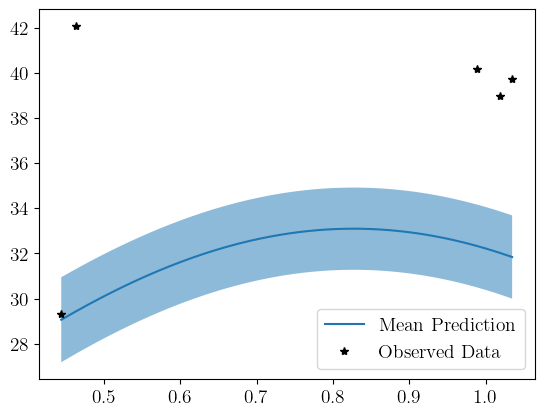

In [97]:
plot_model(model)

In [98]:
def print_parameters(model):
    state_dict = model.state_dict()
    for param_name, param_tensor in state_dict.items():
        print(param_name, param_tensor)

In [99]:
print_parameters(model)

likelihood.noise_covar.raw_noise tensor([0.])
likelihood.noise_covar.raw_noise_constraint.lower_bound tensor(1.0000e-04)
likelihood.noise_covar.raw_noise_constraint.upper_bound tensor(inf)
mean_module.raw_constant tensor(0.)
covar_module.raw_outputscale tensor(0.)
covar_module.base_kernel.raw_lengthscale tensor([[0.]])
covar_module.base_kernel.raw_lengthscale_constraint.lower_bound tensor(0.)
covar_module.base_kernel.raw_lengthscale_constraint.upper_bound tensor(inf)
covar_module.raw_outputscale_constraint.lower_bound tensor(0.)
covar_module.raw_outputscale_constraint.upper_bound tensor(inf)


In [112]:
def train_model(model, train_x, train_y, n_epochs, print_=False):
    # Use the Adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    
    
    # Optimize the model
    
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        output = model(train_x)
        loss = - mll(output, train_y)
        if print_:
            print(f'epoch {epoch}, Loss = {loss}')
        loss.backward()
        optimizer.step()

In [101]:
train_model(model, train_x_a, train_y_a, 50, print_=True)

/usr/local/lib/python3.10/dist-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


epoch 0, Loss = 32.13343923005904
epoch 1, Loss = 18.90470257656888
epoch 2, Loss = 12.75171731272799
epoch 3, Loss = 13.058603050286859
epoch 4, Loss = 16.429029172080263
epoch 5, Loss = 18.465241424820057
epoch 6, Loss = 17.861890025013988
epoch 7, Loss = 15.744049610547572
epoch 8, Loss = 13.588906030082137
epoch 9, Loss = 12.366570871618702
epoch 10, Loss = 12.336090113048817
epoch 11, Loss = 13.132224851874117
epoch 12, Loss = 14.081731196028011
epoch 13, Loss = 14.608519799646349
epoch 14, Loss = 14.48686796997464
epoch 15, Loss = 13.846082890434593
epoch 16, Loss = 13.021371733606765
epoch 17, Loss = 12.371287377155742
epoch 18, Loss = 12.125045075346849
epoch 19, Loss = 12.29447006413872
epoch 20, Loss = 12.685152901505862
epoch 21, Loss = 13.015256925648021
epoch 22, Loss = 13.079390910690629
epoch 23, Loss = 12.850835538659672
epoch 24, Loss = 12.465841066299859
epoch 25, Loss = 12.122408110646301
epoch 26, Loss = 11.965952415824992
epoch 27, Loss = 12.021150615114468
epoch 2

In [102]:
print_parameters(model)

likelihood.noise_covar.raw_noise tensor([0.])
likelihood.noise_covar.raw_noise_constraint.lower_bound tensor(1.0000e-04)
likelihood.noise_covar.raw_noise_constraint.upper_bound tensor(inf)
mean_module.raw_constant tensor(0.3687)
covar_module.raw_outputscale tensor(0.3419)
covar_module.base_kernel.raw_lengthscale tensor([[-0.1518]])
covar_module.base_kernel.raw_lengthscale_constraint.lower_bound tensor(0.)
covar_module.base_kernel.raw_lengthscale_constraint.upper_bound tensor(inf)
covar_module.raw_outputscale_constraint.lower_bound tensor(0.)
covar_module.raw_outputscale_constraint.upper_bound tensor(inf)


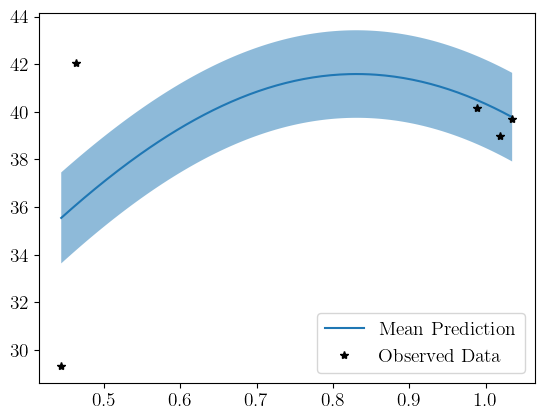

In [103]:
plot_model(model)

In [104]:
class Sample_param:
    def __init__(self, param, size):
        self.param = param
        self.size = size
    def uniform(self):
        param_prefix = get_param_prefix(self.param)
        pre_postfix = param_prefix + ':' + self.param
        return torch.tensor(np.random.uniform(
                low=PARAM_DICT[pre_postfix][0],
                high=PARAM_DICT[pre_postfix][1],
                size=self.size))

    def linspace(self):
        param_prefix = get_param_prefix(self.param)
        pre_postfix = param_prefix + ':' + self.param
        return torch.linspace(start=PARAM_DICT[pre_postfix][0],
                end=PARAM_DICT[pre_postfix][1],
                steps=self.size)

In [109]:
def BayesOpt(model, train_x, train_y, n_epochs):
    # Use the Adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for epoch in range(n_epochs):
        model.eval()
        likelihood.eval()
        x_candidates = Sample_param(param='aLund',size=10).uniform()
        ei = expected_improvement(model, train_y, x_candidates)
        ei_argmax = ei.argmax()
        next_x = x_candidates[ei_argmax]
        next_y = true_objective_func(next_x.float())
        train_x = torch.cat([train_x, next_x.unsqueeze(-1)])
        next_y = torch.tensor([next_y])
        train_y = torch.cat([train_y, next_y])

        model.set_train_data(inputs=train_x, targets=train_y, strict=False)

In [110]:
BayesOpt(model, train_x_a, train_y_a, 10)


 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 75fc85f49008 (x86_64) at 2024-06-24 01:09:42
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:01 elapsed)
Event 200 (0:00:01 elapsed)
Event 300 (0:00:01 elapsed)
Event 400 (0:00:01 elapsed)
Event 500 (0:00:01 elapsed)
Finished event loop at 2024-06-24 01:09:43
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-24 01:09:43, time elapsed = 0:00:01
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 16.06it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw  sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   7.600000   3.04  0.028237  0.022245        19.0
1  0.005  0.010  17.600000   7.04  0.134378  0.213324        44.0
2  0.010  0.015  18.000000   7.20  0.228096  0.586534        45.0
3  0.015  0.020  14.400000   5.76  0.251038  0.883379        36.0
4  0.020  0.025  16.799999   6.72  0.382599  1.749604        42.0
 new data keys ['/REF/AL

objective function = 3.1593902290907416

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A           

Rivet 3.1.9 running on machine 75fc85f49008 (x86_64) at 2024-06-24 01:09:46
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Finished event loop at 2024-06-24 01:09:46
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-24 01:09:46, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.93it/s]


using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh  sumw  sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   6.4   2.56  0.024028  0.018712        16.0
1  0.005  0.010  20.4   8.16  0.162021  0.266289        51.0
2  0.010  0.015  20.4   8.16  0.256442  0.654184        51.0
3  0.015  0.020  18.0   7.20  0.317818  1.129889        45.0
4  0.020  0.025  17.6   7.04  0.397034  1.798805        44.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01'

Rivet 3.1.9 running on machine 75fc85f49008 (x86_64) at 2024-06-24 01:09:49
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:01 elapsed)
Event 500 (0:00:01 elapsed)
Finished event loop at 2024-06-24 01:09:50
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-24 01:09:50, time elapsed = 0:00:01
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.11it/s]


using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw  sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   4.800000   1.92  0.016537  0.011778        12.0
1  0.005  0.010  25.600000  10.24  0.195653  0.311181        64.0
2  0.010  0.015  21.200001   8.48  0.260800  0.649661        53.0
3  0.015  0.020  17.600000   7.04  0.310455  1.103280        44.0
4  0.020  0.025  16.000000   6.40  0.361505  1.638869        40.0
 new data keys ['/REF/AL

Rivet 3.1.9 running on machine 75fc85f49008 (x86_64) at 2024-06-24 01:09:53
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Finished event loop at 2024-06-24 01:09:53
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-24 01:09:53, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.04it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh  sumw  sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   4.4   1.76  0.016187  0.012672        11.0
1  0.005  0.010  22.0   8.80  0.164657  0.253216        55.0
2  0.010  0.015  22.0   8.80  0.271825  0.678992        55.0
3  0.015  0.020  21.6   8.64  0.376214  1.319882        54.0
4  0.020  0.025  14.8   5.92  0.334811  1.520412        37.0


 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01', '/REF/ALEPH_1996_S3486095/d06-x01-y01', '/REF/ALEPH_1996_S3486095/d07-x01-y01', '/REF/ALEPH_1996_S3486095/d08-x01-y01', '/REF/ALEPH_1996_S3486095/d09-x01-y01', '/REF/ALEPH_1996_S3486095/d10-x01-y01', '/REF/ALEPH_1996_S3486095/d11-x01-y01', '/REF/ALEPH_1996_S3486095/d12-x01-y01', '/REF/ALEPH_1996_S3486095/d17-x01-y01', '/REF/ALEPH_1996_S3486095/d18-x01-y01', '/REF/ALEPH_1996_S3486095/d25-x01-y01', '/REF/ALEPH_1996_S3486095/d26-x01-y01', '/REF/ALEPH_1996_S3486095/d27-x01-y01', '/REF/ALEPH_1996_S3486095/d28-x01-y01', '/REF/ALEPH_1996_S3486095/d29-x01-y01', '/REF/ALEPH_1996_S3486095/d30-x01-y01', '/REF/ALEPH_1996_S3486095/d31-x01-y01', '/REF/ALEPH_1996_S3486095/d32-x01-y01', '/REF/ALEPH_1996_S3486095/d33-x01-y01', '/REF/ALEPH_1996_S3486095/d34-x01-y01', '/REF/ALEPH_1996_S348609

Rivet 3.1.9 running on machine 75fc85f49008 (x86_64) at 2024-06-24 01:09:56
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Finished event loop at 2024-06-24 01:09:56
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-24 01:09:56, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 15.26it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw  sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   5.200000   2.08  0.019944  0.015949        13.0
1  0.005  0.010  17.200001   6.88  0.135378  0.218754        43.0
2  0.010  0.015  24.000000   9.60  0.293872  0.730858        60.0
3  0.015  0.020  21.200001   8.48  0.370501  1.303610        53.0
4  0.020  0.025  11.600000   4.64  0.261662  1.186194        29.0
 new data keys ['/REF/AL

objective function = 3.9179963982999335

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A           

Rivet 3.1.9 running on machine 75fc85f49008 (x86_64) at 2024-06-24 01:09:59
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:01 elapsed)
Finished event loop at 2024-06-24 01:10:00
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-24 01:10:00, time elapsed = 0:00:01
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.90it/s]


using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw  sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   4.400000   1.76  0.016269  0.012790        11.0
1  0.005  0.010  18.400000   7.36  0.136194  0.208390        46.0
2  0.010  0.015  24.000000   9.60  0.297579  0.746972        60.0
3  0.015  0.020  18.799999   7.52  0.331982  1.178816        47.0
4  0.020  0.025  17.200001   6.88  0.389069  1.766628        43.0
 new data keys ['/REF/AL

Rivet 3.1.9 running on machine 75fc85f49008 (x86_64) at 2024-06-24 01:10:03
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Finished event loop at 2024-06-24 01:10:03
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-24 01:10:03, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.04it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME


    xlow  xhigh       sumw  sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   9.600000   3.84  0.035981  0.029157        24.0
1  0.005  0.010  22.799999   9.12  0.172021  0.267892        57.0
2  0.010  0.015  21.200001   8.48  0.262613  0.660006        53.0
3  0.015  0.020  16.000000   6.40  0.281519  0.997320        40.0
4  0.020  0.025  13.600000   5.44  0.301980  1.346028        34.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01', '/REF/ALEPH_1996_S3486095/d06-x01-y01', '/REF/ALEPH_1996_S3486095/d07-x01-y01', '/REF/ALEPH_1996_S3486095/d08-x01-y01', '/REF/ALEPH_1996_S3486095/d09-x01-y01', '/REF/ALEPH_1996_S3486095/d10-x01-y01', '/REF/ALEPH_1996_S3486095/d11-x01-y01', '/REF/ALEPH_1996_S3486095/d12-x01-y01', '/REF/ALEPH_1996_S3486095/d17-x01-y01', '/REF/ALEPH_1996_S3486095/d18-x01-y01', '/REF/ALEPH_1996_S3486095/d2

Rivet 3.1.9 running on machine 75fc85f49008 (x86_64) at 2024-06-24 01:10:06
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Finished event loop at 2024-06-24 01:10:06
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-24 01:10:06, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.78it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh  sumw  sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   5.2   2.08  0.018230  0.014295        13.0
1  0.005  0.010  19.6   7.84  0.152908  0.246076        49.0
2  0.010  0.015  22.4   8.96  0.278781  0.702090        56.0
3  0.015  0.020  14.0   5.60  0.242746  0.847936        35.0
4  0.020  0.025  12.4   4.96  0.278925  1.259050        31.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01'

objective function = 3.9915771288800674

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A           

Rivet 3.1.9 running on machine 75fc85f49008 (x86_64) at 2024-06-24 01:10:09
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Finished event loop at 2024-06-24 01:10:09
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-24 01:10:09, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 15.81it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw  sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   5.600000   2.24  0.020072  0.015344        14.0
1  0.005  0.010  19.200001   7.68  0.145943  0.230006        48.0
2  0.010  0.015  20.799999   8.32  0.264699  0.683419        52.0
3  0.015  0.020  16.400000   6.56  0.285756  1.000627        41.0
4  0.020  0.025  16.400000   6.56  0.364154  1.624940        41.0
 new data keys ['/REF/AL

objective function = 3.4951339391799867

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A           

Rivet 3.1.9 running on machine 75fc85f49008 (x86_64) at 2024-06-24 01:10:11
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:01 elapsed)
Event 200 (0:00:01 elapsed)
Event 300 (0:00:01 elapsed)
Event 400 (0:00:01 elapsed)
Event 500 (0:00:01 elapsed)
Finished event loop at 2024-06-24 01:10:12
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-24 01:10:12, time elapsed = 0:00:01
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 15.96it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw  sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   5.600000   2.24  0.019912  0.015311        14.0
1  0.005  0.010  16.000000   6.40  0.121982  0.192428        40.0
2  0.010  0.015  25.200001  10.08  0.314244  0.793656        63.0
3  0.015  0.020  19.200001   7.68  0.334422  1.174511        48.0
4  0.020  0.025  12.800000   5.12  0.288425  1.305549        32.0
 new data keys ['/REF/AL

objective function = 4.00224907080604


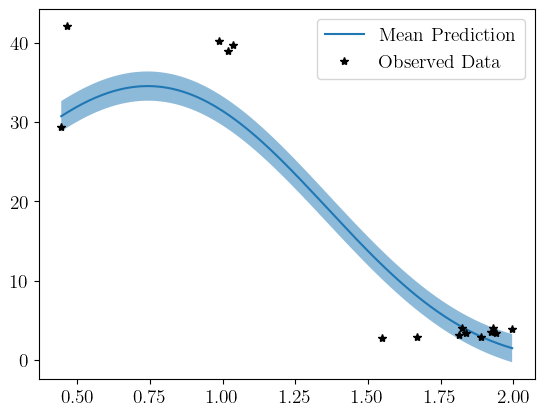

In [111]:
plot_model(model)

In [143]:
pred_mean = pred.mean.numpy()
param = a_linspace.numpy()
best_x = param[pred_mean.argmin()]
print(f'minimum of mean value function = {best_x}')
observed_min = train_x_a[train_y_a.argmin()]
print(f'observed minimum in data = {observed_min}')

minimum of mean value function = 0.5
observed minimum in data = 0.7073398900656088
